In [60]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
from keras import metrics
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback 

In [61]:
X_train = pd.read_csv('data/X_train.csv')
Y_train =  pd.read_csv('data/Y_train.csv')
X_val = pd.read_csv('data/X_val.csv')
Y_val = pd.read_csv('data/Y_val.csv')

X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)


original_indexes = X_val.index.tolist()
original_names = X_val['name_normalized'].tolist()
original_positions = X_val['position'].tolist()
original_teams =  X_val['player_team_name'].tolist()


# Assuming df is your DataFrame and 'name_normalized' is the column with player names
X_train['player_id'] = pd.factorize(X_train['name_normalized'])[0]
X_val['player_id'] = pd.factorize(X_val['name_normalized'])[0]
# Now, 'player_id' is a numeric representation of 'name_normalized'
Y_train['player_id'] = pd.factorize(Y_train['name_normalized'])[0]
Y_val['player_id'] = pd.factorize(Y_val['name_normalized'])[0]

X_train.drop('name_normalized', axis=1, inplace=True)
X_val.drop('name_normalized', axis=1, inplace=True)
Y_train.drop('name_normalized', axis=1, inplace=True)
Y_val.drop('name_normalized', axis=1, inplace=True)

# Test Data

X_test = pd.read_csv('data/feat_eng/alpha-StandardScaling-X_test-alldata.csv')
y_test = pd.read_csv('data/feat_eng/alpha-StandardScaling-Y_test-alldata.csv')

X_test.drop(columns=['Unnamed: 0', 'sequence'], inplace=True)
y_test.drop(columns=['Unnamed: 0'], inplace=True)

X_test['player_id'] = pd.factorize(X_test['name_normalized'])[0]
y_test['player_id'] = pd.factorize(y_test['name_normalized'])[0]
X_test.drop('name_normalized', axis=1, inplace=True)
y_test.drop('name_normalized', axis=1, inplace=True)

# Need this for post mortem later
original_mapping_test = X_test[['player_id', 'player_team_name', 'position']].copy()


## Sequence Slicing

In [62]:


def one_hot_encode_categorical(train_df, val_df, test_df, categorical_vars):
    for var in categorical_vars:
        # Fit the encoder on the training set
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        train_column = train_df[[var]]

        # Fit and transform training set
        encoded_train = encoder.fit_transform(train_column)
        encoded_train_df = pd.DataFrame(encoded_train, columns=[f'{var}_{cat}' for cat in encoder.get_feature_names_out([var])])
        train_df = pd.concat([train_df, encoded_train_df], axis=1)

        # Transform validation set, handle unknown categories
        val_column = val_df[[var]]
        encoded_val = encoder.transform(val_column)
        encoded_val_df = pd.DataFrame(encoded_val, columns=[f'{var}_{cat}' for cat in encoder.get_feature_names_out([var])])
        val_df = pd.concat([val_df, encoded_val_df], axis=1)

        # Transform test set, handle unknown categories
        test_column = test_df[[var]]
        encoded_test = encoder.transform(test_column)
        encoded_test_df = pd.DataFrame(encoded_test, columns=[f'{var}_{cat}' for cat in encoder.get_feature_names_out([var])])
        test_df = pd.concat([test_df, encoded_test_df], axis=1)

        # Drop the original column in both sets
    
        train_df = train_df.drop([var], axis=1)
        val_df = val_df.drop([var], axis=1)
        test_df = test_df.drop([var], axis=1)
        

    return train_df, val_df, test_df

NONE_SEQ_CAT_VARS = ['player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home']

# Run for train, val
X_train, X_val, X_test = one_hot_encode_categorical(X_train, X_val, X_test, NONE_SEQ_CAT_VARS)



# Example function to create sequences and align targets
def create_sequences_and_targets(X, Y, sequence_length):
    """Returns a tensorys x, y and a df with cols: player_id, index"""
    sequences = []
    targets = []
    player_mapping = {'player_id': [], 'tensor_index': []}

    for player_id, group in X.groupby('player_id'):
        player_targets = Y[Y['player_id'] == player_id]['total_points']

        for start_idx in range(len(group) - sequence_length + 1):
            end_idx = start_idx + sequence_length
            sequences.append(group.iloc[start_idx:end_idx].values)
            targets.append(player_targets.iloc[end_idx - 1])  # Aligning target
            player_mapping['player_id'].append(player_id)
            player_mapping['tensor_index'].append(len(targets) - 1)

    return np.array(sequences), np.array(targets), pd.DataFrame(player_mapping)



In [63]:
all_cols = X_train.columns

cats_prefix = ('player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home', 'season')

categorical_cols = [col for col in X_train.columns if col.startswith(cats_prefix)]


lag_1 = ['assists_lag_1', 'bonus_lag_1', 'bps_lag_1', 'clean_sheets_lag_1',
       'creativity_lag_1', 'goals_conceded_lag_1', 'goals_scored_lag_1',
       'ict_index_lag_1', 'influence_lag_1', 'minutes_lag_1',
       'own_goals_lag_1', 'penalties_missed_lag_1', 'penalties_saved_lag_1',
       'red_cards_lag_1', 'saves_lag_1', 'selected_lag_1',
       'player_team_score_lag_1', 'opp_team_score_lag_1', 'threat_lag_1',
       'total_points_lag_1', 'value_lag_1', 'yellow_cards_lag_1']

lag_3 = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']

lag_5 = ['assists_lag_5', 'bonus_lag_5', 'bps_lag_5', 'clean_sheets_lag_5',
       'creativity_lag_5', 'goals_conceded_lag_5', 'goals_scored_lag_5',
       'ict_index_lag_5', 'influence_lag_5', 'minutes_lag_5',
       'own_goals_lag_5', 'penalties_missed_lag_5', 'penalties_saved_lag_5',
       'red_cards_lag_5', 'saves_lag_5', 'selected_lag_5',
       'player_team_score_lag_5', 'opp_team_score_lag_5', 'threat_lag_5',
       'total_points_lag_5', 'value_lag_5', 'yellow_cards_lag_5']

In [64]:
cont_settings = {
    'all': [lag_1, lag_3, lag_5],
    'one': [lag_1],
    'three': [lag_3],
    'five': [lag_5],
}
cat_settings = {
    'nil': [],
    'all': ['player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home'],
    'basic': ['was_home', 'position'],
    'base_team': ['was_home', 'position', 'player_team_name'],
    'base_team_opp': ['was_home', 'position', 'player_team_name', 'opp_team_name'],
    'base_team_diff': ['was_home', 'position', 'player_team_name', 'opp_diff_ind'],
    'base_team_opp_diff': ['was_home', 'position', 'player_team_name', 'opp_team_name', 'opp_diff_ind'],
}

In [65]:
def col_and_seq_pipeline(x_train, y_train, x_val, y_val, x_test, y_test, cat, cont, seq_len):
    def select_columns(df, categorical_prefixes, continuous_sets):
    # Select categorical columns based on prefixes
        categorical_cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in categorical_prefixes)]
        
        # Select continuous columns based on specified sets
        continuous_cols = ['player_id']
        for continuous_set in continuous_sets:
            continuous_cols.extend(continuous_set)
        
    
        # Combine selected categorical and continuous columns
        selected_cols = categorical_cols + continuous_cols
        return df[selected_cols]
    train_feat_reduced = select_columns(x_train, cat, cont)
    val_feat_reduced = select_columns(x_val, cat, cont)
    test_feat_reduced = select_columns(x_test, cat, cont)
    x_t, y_t, _ = create_sequences_and_targets(train_feat_reduced, y_train, seq_len)
    x_v, y_v, _ = create_sequences_and_targets(val_feat_reduced, y_val, seq_len)
    x_test, y_test, mapping = create_sequences_and_targets(val_feat_reduced, y_val, seq_len)
    return x_t, y_t, x_v, y_v, x_test, y_test, mapping

In [66]:
def plot_history(history):
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    
    # Define custom colors for better visualization
    colors = {
        'train_loss': '#1f77b4',
        'val_loss': '#ff7f0e',
        'train_mse': '#FFA500',
        'val_mse': '#d62728',
        'train_mae': '#9467bd',
        'val_mae': '#8c564b'
    }
    
    # Create a figure with subplots
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(13, 5))
    
    # Plot Training and Validation Loss
    ax1.plot(x_arr, hist['loss'], '-o', color=colors['train_loss'], label='Train Loss')
    ax1.plot(x_arr, hist['val_loss'], '--<', color=colors['val_loss'], label='Validation Loss')
    ax1.legend(fontsize=12)
    ax1.set_xlabel('Epoch', size=12)
    ax1.set_ylabel('Loss', size=12)
    ax1.set_title('Loss by Epoch', size=14)
    # ax1.axhline(y=MSE(true, pred), color='limegreen', linestyle='-', label='MSE(true, pred)')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    
    # Plot Training and Validation MAE
    ax3.plot(x_arr, hist['mean_absolute_error'], '-o', color=colors['train_mae'], label='Train MAE')
    ax3.plot(x_arr, hist['val_mean_absolute_error'], '--<', color=colors['val_mae'], label='Validation MAE')
    ax3.legend(fontsize=12)
    ax3.set_xlabel('Epoch', size=12)
    ax3.set_ylabel('MAE', size=12)
    ax3.set_title('MAE by Epoch', size=14)
    # ax3.axhline(y=MAE(true, pred), color='limegreen', linestyle='-', label='MSE(true, pred)')
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [67]:
def compile_and_run_ls7(train_seq, y_train_seq, val_seq, y_val_seq, **kwargs):
    print("kwArgs: ", kwargs)
    sequence_length = train_seq.shape[1]
    num_features = train_seq.shape[2]
    lstm_size = kwargs.get('lstm_size', 50)
    epochs = kwargs.get('epochs', 2)    
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    dropout_rate = kwargs.get('dropout_rate', 0.5)

    model = Sequential([
        LSTM(lstm_size, return_sequences=True, input_shape=(sequence_length, num_features), name='LSTM1'),
        Dropout(dropout_rate, name='drop1'),
        LSTM(lstm_size, return_sequences=True, name='LSTM2'),
        Dropout(dropout_rate, name='drop2'),
        LSTM(lstm_size, return_sequences=True, name='LSTM3'),
        Dropout(dropout_rate, name='drop3'),
        LSTM(lstm_size, return_sequences=True, name='LSTM4'),
        Dropout(dropout_rate, name='drop4'),
        LSTM(lstm_size, return_sequences=True, name='LSTM5'),
        Dropout(dropout_rate, name='drop5'),
        LSTM(lstm_size, return_sequences=True, name='LSTM6'),
        Dropout(dropout_rate, name='drop6'),
        LSTM(lstm_size, return_sequences=False, name='LSTM7'),
        Dropout(dropout_rate, name='drop7'),
        Dense(units=1, activation='linear', name='Dense1')
    ])
    lr = kwargs.get("learning_rate", 0.001)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    # print(f"Training model with learning rate: {lr}")
    history = model.fit(train_seq, y_train_seq, epochs=epochs, batch_size=kwargs.get('batch_size',32), 
                        validation_data=(val_seq, y_val_seq), verbose=0,
                       callbacks=[TqdmCallback()])

    return model, history

# FINAL MODEL

In [ ]:
train_seq, y_train_seq, val_seq, y_val_seq, x_test, y_test, seq_mapping = col_and_seq_pipeline(
    X_train, Y_train, X_val, Y_val, X_test, y_test, cat_settings.get('all'), cont_settings.get('all'), 7
)

model, history = compile_and_run_ls7(
    train_seq, y_train_seq, val_seq, y_val_seq, 
    seq_length=7, lstm_size=200, 
    cat_key='all', con_key='all', 
    learning_rate=0.001, dropout_rate=0.3,
    batch_size=32,
    epochs=45
)

kwArgs:  {'seq_length': 7, 'lstm_size': 200, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.3, 'batch_size': 32, 'epochs': 45}


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

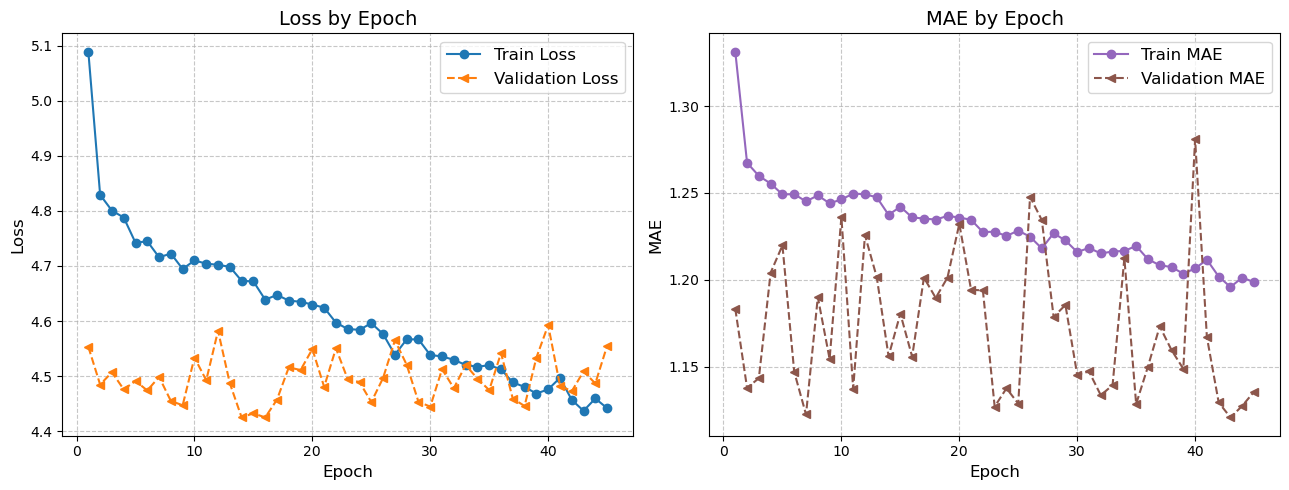

In [43]:
plot_history(history)

## Test Data Predictions

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(x_test, verbose=0)



# Calculate regression metrics

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print or use these metrics as needed
print("Test Statistics")
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Test Statistics
Mean Squared Error (MSE): 4.555122752978678
Mean Absolute Error (MAE): 1.1357189587831271
R-squared (R2): 0.2472644743361


In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 7, 200)            292800    
                                                                 
 drop1 (Dropout)             (None, 7, 200)            0         
                                                                 
 LSTM2 (LSTM)                (None, 7, 200)            320800    
                                                                 
 drop2 (Dropout)             (None, 7, 200)            0         
                                                                 
 LSTM3 (LSTM)                (None, 7, 200)            320800    
                                                                 
 drop3 (Dropout)             (None, 7, 200)            0         
                                                                 
 LSTM4 (LSTM)                (None, 7, 200)            3

In [47]:
unique_player_stats_by_id = original_mapping_test.drop_duplicates(subset='player_id', keep='last')


In [48]:
seq_mapping.head()

,player_id,tensor_index
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


In [49]:
df_results = pd.DataFrame({'truth': y_test, 'pred': y_pred.reshape(21060)})
df_results

,truth,pred
0,0,0.268891
1,0,0.151643
2,0,1.125131
3,0,0.156722
4,0,0.145718
...,...,...
21055,0,2.015152
21056,0,1.123247
21057,0,0.861233
21058,0,0.706984


In [50]:
post_mortem_df = pd.concat([seq_mapping, df_results, ], axis=1)
post_mortem_df = post_mortem_df.merge(right=unique_player_stats_by_id, on='player_id')
post_mortem_df['error'] = post_mortem_df['truth'] - post_mortem_df['pred']
post_mortem_df

,player_id,tensor_index,truth,pred,player_team_name,position,error
0,0,0,0,0.268891,West Ham,DEF,-0.268891
1,0,1,0,0.151643,West Ham,DEF,-0.151643
2,0,2,0,1.125131,West Ham,DEF,-1.125131
3,0,3,0,0.156722,West Ham,DEF,-0.156722
4,0,4,0,0.145718,West Ham,DEF,-0.145718
...,...,...,...,...,...,...,...
21055,734,21055,0,2.015152,Leeds,MID,-2.015152
21056,734,21056,0,1.123247,Leeds,MID,-1.123247
21057,734,21057,0,0.861233,Leeds,MID,-0.861233
21058,734,21058,0,0.706984,Leeds,MID,-0.706984


In [52]:
team_error_analysis = post_mortem_df.groupby('player_team_name')['error'].mean()
print("Errors by Team:")
print(team_error_analysis)


Errors by Team:
player_team_name
Arsenal           0.101182
Aston Villa       0.041463
Bournemouth      -0.097096
Brentford        -0.004856
Brighton          0.036982
Chelsea          -0.068884
Crystal Palace    0.046600
Everton           0.046564
Fulham            0.017964
Leeds             0.145206
Leicester        -0.009509
Liverpool         0.029589
Man City          0.081366
Man Utd           0.127287
Newcastle         0.093630
Nott'm Forest     0.126746
Southampton       0.071807
Spurs             0.172926
West Ham         -0.017518
Wolves            0.056462
Name: error, dtype: float64


In [53]:
position_error_analysis = post_mortem_df.groupby('position')['error'].mean()
print("\nErrors by Position:")
print(position_error_analysis)



Errors by Position:
position
DEF    0.045674
FWD   -0.023032
GK     0.011966
MID    0.082200
Name: error, dtype: float64


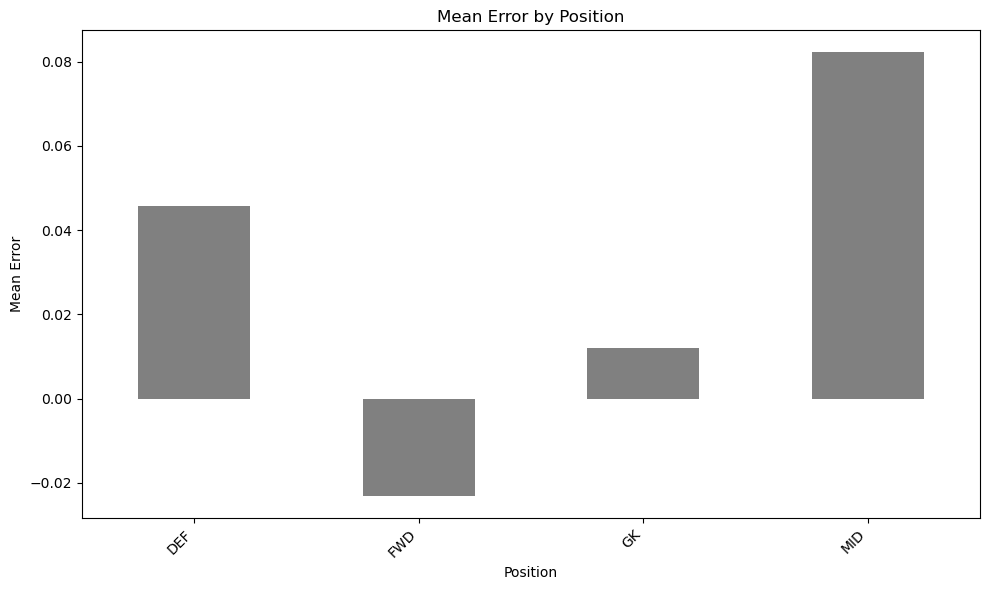

In [59]:


# Assuming position_error_analysis is a pandas Series
position_error_analysis = post_mortem_df.groupby('position')['error'].mean()

# Create a bar graph
plt.figure(figsize=(10, 6))
position_error_analysis.plot(kind='bar', color='grey')
plt.title('Mean Error by Position')
plt.xlabel('Position')
plt.ylabel('Mean Error')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/yc/p4crn8cj0tz82_rx5_032qvw0000gn/T/ipykernel_40909/4114577593.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  true_score_error_analysis = post_mortem_df.groupby('true_score_bins')['error'].mean()


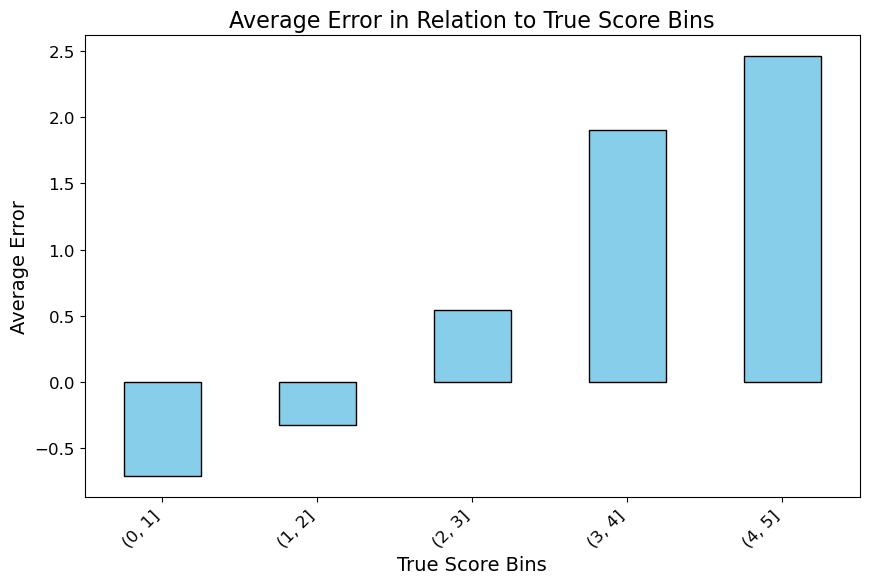

In [55]:


# Create bins for true scores
bins = [0, 1, 2, 3, 4, 5]
post_mortem_df['true_score_bins'] = pd.cut(post_mortem_df['truth'], bins)

# Group by true_score_bins and calculate the mean error
true_score_error_analysis = post_mortem_df.groupby('true_score_bins')['error'].mean()

# Plot the histogram
fig, ax = plt.subplots(figsize=(10, 6))
true_score_error_analysis.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Average Error in Relation to True Score Bins', fontsize=16)
plt.xlabel('True Score Bins', fontsize=14)
plt.ylabel('Average Error', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()


In [56]:
post_mortem_df.pred.mean()

1.1878386

In [57]:
post_mortem_df.truth.mean()

1.2376068376068377

In [58]:
Y_train['total_points'].mean()

1.3593784070590629